In [2]:
import re
import pandas as pd
from pprint import pprint
from pytube import Channel, Playlist
from tqdm import tqdm
from multiprocessing.pool import ThreadPool as Pool

In [3]:
class NoPlaylistsFound(Exception):
    def __init__(self, message, errors=None):
        super().__init__(message, errors=errors)
        self.message = message
        self.errors = errors

In [4]:
class ChannelDataParser:
    
    def __init__(self, channel_url):
        self.channel_url = channel_url
        self._channel_info = []
        self.playlists = None
        
        self.pool_size = 10
        self.pool = Pool(processes=self.pool_size)
        
        
    @property
    def channel_info(self):
        return self._channel_info
    
    @channel_info.setter
    def channel_info(self, value):
        raise ValueError("cannot set value to chennel_info only populated")
        
    @property
    def channel_data(self):
        return pd.concat(self.channel_info, axis=0)
    
    @staticmethod
    def get_channel_playlists(channel_url):
        """
        function to get the playlists in a youtube channel.

        Args
        ----
         - channel_url (str) : the url of the youtube channel.

        Returns
        -------
         - playlists (list) : list of all unique playlists in the channel

        Raises
        ------
         - NoPlaylistsFound
        """

        ch = Channel(url=channel_url)

        playlists_html = ch.playlists_html

        pattern = re.compile(r'{"url":"/\w*\?list=\w*')

        playlists_uncleaned = re.findall(pattern, playlists_html)

        playlists_cleaned = set(map(lambda x: x.replace('{"url":"/', ""), playlists_uncleaned))

        if not playlists_cleaned:
            raise NoPlaylistsFound("No playlists found in this channel")

        return list(playlists_cleaned)
    
    def get_playlist_videos_info(self, playlist_url):
        """
        function parse videos from the playlist and gets their info.

        Args
        ----
         - playlist_url (str) : the url of the playlist.

        Returns
        -------
         - videos_info (list) : a 2D list containg a info about videos in the playlist
        """

        playlist_videos_data = dict(
            playlist_id=[], playlist_title=[], playlist_owner_id=[], playlist_length=[],
            playlist_views=[], video_id=[], video_title=[], video_views=[], video_length=[],
            video_desciption=[], video_keywords=[], video_rating=[],
        )

        ## base url of the youtube for the playlists
        YOUTUBE_BASE = "https://www.youtube.com/"

        playlist_url = YOUTUBE_BASE + playlist_url

        try:

            playlist = Playlist(url=playlist_url)
            
            for video in playlist.videos:
                print(".", end="")
                
                try:
                    playlist_videos_data["playlist_id"].append(playlist.playlist_id)
                    playlist_videos_data["playlist_title"].append(playlist.title)
                    playlist_videos_data["playlist_owner_id"].append(playlist.owner_id)
                    playlist_videos_data["playlist_length"].append(playlist.length)
                    playlist_videos_data["playlist_views"].append(playlist.views)

                    playlist_videos_data["video_id"].append(video.video_id)
                    playlist_videos_data["video_title"].append(video.title)
                    playlist_videos_data["video_views"].append(video.views)
                    playlist_videos_data["video_length"].append(video.length)
                    playlist_videos_data["video_desciption"].append(video.description)
                    playlist_videos_data["video_keywords"].append(video.keywords)
                    playlist_videos_data["video_rating"].append(video.rating)
                except Exception as e:
                    playlist_videos_data["playlist_id"].append(None)
                    playlist_videos_data["playlist_title"].append(None)
                    playlist_videos_data["playlist_owner_id"].append(None)
                    playlist_videos_data["playlist_length"].append(None)
                    playlist_videos_data["playlist_views"].append(None)

                    playlist_videos_data["video_id"].append(None)
                    playlist_videos_data["video_title"].append(None)
                    playlist_videos_data["video_views"].append(None)
                    playlist_videos_data["video_length"].append(None)
                    playlist_videos_data["video_desciption"].append(None)
                    playlist_videos_data["video_keywords"].append(None)
                    playlist_videos_data["video_rating"].append(None)
            
            playlist_data = pd.DataFrame(playlist_videos_data)
            self.channel_info.append(playlist_data)
            print()
            
        except Exception as e:
            print(f"[ERROR] {str(e)}")

        return playlist_videos_data
    
    def get_channel_data_async(self):
        self.playlists = self.get_channel_playlists(self.channel_url)
        
        for playlist in self.playlists:
            try:
                self.pool.apply_async(self.get_playlist_videos_info, (playlist, ))
            except Exception as e:
                print(f"[ERROR] {str(e)}")
                
        self.pool.close()
        self.pool.join()
    
    def get_channel_data(self):
        """
        function to get video information of all playlists

        Args
        ----
         - playlists (list) : the playlists of the channel

        Returns
        -------
         - channel_data (pd.DataFrame) : all the data from playlists passed
        """
        
        self.playlists = self.get_channel_playlists(self.channel_url)
        
        for playlist in self.playlists:
            try:
                playlist_info = self.get_playlist_videos_info(playlist)
                playlist_data = pd.DataFrame(playlist_info)
                self.channel_info.append(playlist_data)
            except Exception as e:
                print(f"[ERROR] {str(e)}")

        return self.channel_data


In [5]:
from time import time

s = time()

MIT_URL = "https://www.youtube.com/c/mitocw/"
ch = ChannelDataParser(channel_url=MIT_URL)
ch_data = ch.get_channel_data_async()

print("Done Parsing Data in {:.5f}".format(time() - s))

....
.......................
......................
..
................
.....
..................................................................................................................

.............
.[ERROR] All arrays must be of the same length


.....
..
...
...............
...........
............................................
.
...
.......
.....................
..............................................................................................
..........
......
...........

..........................................
................
.....
.................................
...........................
..............

.........
.....
................
.[ERROR] All arrays must be of the same length
......[ERROR] All arrays must be of the same length
.............
..
....
...............[ERROR] All arrays must be of the same length
......................[ERROR] All arrays must be of the same length
..............
...........
.........................................

In [8]:
ch_data = ch.channel_data
ch_data.shape

(1601, 12)

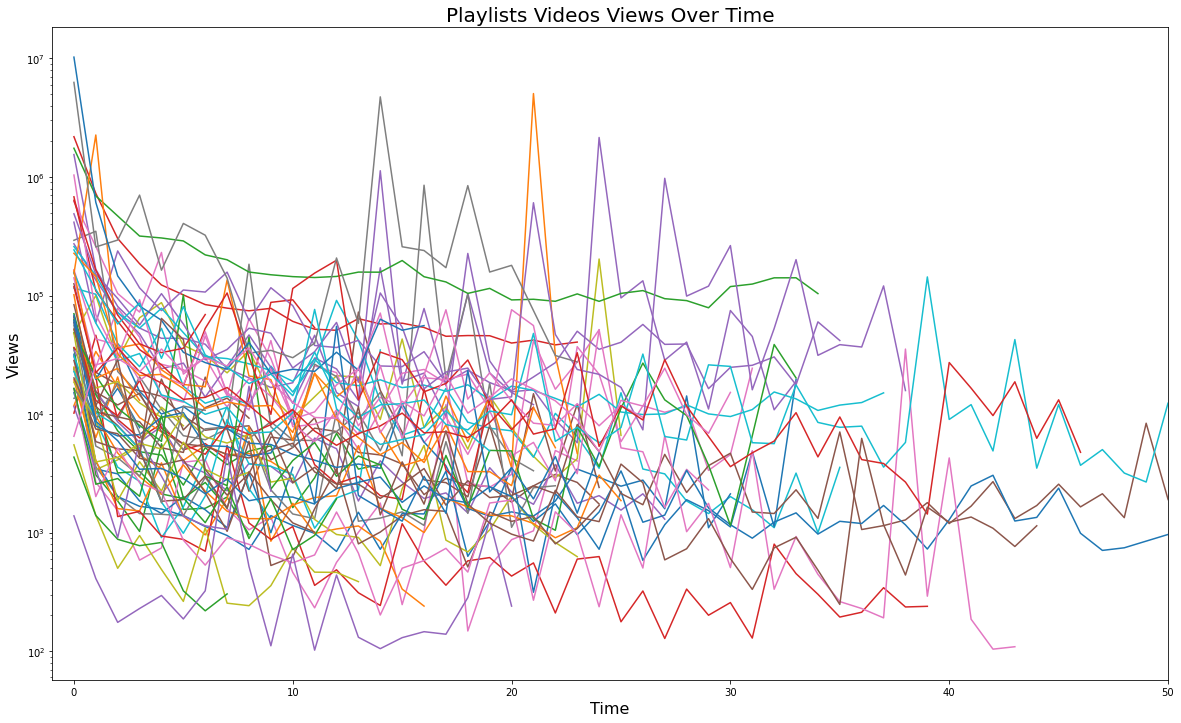

In [9]:
import matplotlib.pyplot as plt

unique_ids = ch_data["playlist_id"].unique()

plt.figure(figsize=(20, 12))
for playlist_id in unique_ids:
    plt.plot(ch_data[ch_data["playlist_id"] == playlist_id]["video_views"].values,
             label=playlist_id)
plt.yscale("log")
plt.xlim([-1, 50])
plt.ylabel("Views", fontsize=16)
plt.xlabel("Time", fontsize=16);
plt.title("Playlists Videos Views Over Time", fontsize=20);
plt.savefig("view_rate.jpg", dpi=200)

In [10]:
ch_data.to_csv("mitocw_data.csv")